In [ ]:
camaracqamqimport os
try:
    from google.colab import drive
    COLAB = True
    print("Estoy en Google CoLab")
    %tensorflow_version 2.x
    !pip install livelossplot
except:
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    print("No estoy en Google CoLab")
    COLAB = False

Estoy en Google CoLab


In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import os
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow
%matplotlib inline

tensorflow.compat.v1.disable_eager_execution()
keras.__version__

'2.8.0'

# Neural style transfer

Existe muchas variantes del algoritmo de transferencia de estilo basados en el original que se han ido adaptando y mejorando. Algunos de ellos incluso se han adaptado para ser usado en aplicaciones móviles. Por simplicidad nos centraremos en el algoritmo descrito en el artículo original.

La transferencia de estilo consiste en aplicar el estilo, usualmente pictórico, de una imagen de referencia a otra imagen, normalmente una fotográfía:

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

Lo que nosotros entenderemos por "estilo" es esencialmente las texturas, colores y los patrones visuales de la imagen en varias escalas espaciales. Por otro lado, entenderemos por "contenido" a la macroestructura de la imagen. Por ejemplo, en la imagen anterior los trazos circulares azules y amarillos son considerados estilos, mientras que los edificios de la fotografía son considerados "contenido".

La idea detrás de la transferencia de estilo está muy relacionada con la generación de texturas que ha sido muy estudiada en el procesamiento de imágenes. Sin embargo los resultados obtenidos con técnicas de deep learning mejoran enormemente los obtenidos previamente con las técnicas clásicas de procesamiento de imágenes.

La noción clave detrás de esta técnica es la misma que la hemos visto en varias aplicaciones anteriormente: definir una función de coste que especifique que queremos alcazar a travéz de la minimización. En este caso lo que queremos alcazar es la conservación del "contenido" de la imagen orinal mientras se adopta el "estilo" de la imagen de referencia. Si somos capaces de definir matemáticamente que es el contenido y que es el estilo entonces podremos definir esta función de coste como:

$$
loss = distancia(estilo(imagen\_de\_ref) - estilo(imagen\_gen)) +
       distancia(contenido(imagen\_orig) - contenido(imagen\_gen))
$$


Donde la "distancia" será la norma L2, $contenido$ una función que data una imagen extrae su "contenido" y $estilo$ es una función que dada una imagen extrae su "estilo"

Minimizando esta función de coste conseguiremos que $estilo(imagen\_gen)$ se aproxime a $estilo(imagen\_ref)$ y que $contenido(imagen\_gen)$ se aproxime a $contenido(imagen\_gen)$.

Una observación fundamental realizada por Gatus y otros fue que la redes convolucionales ofrecen precisamente un forma para definir matemáticamente el "estilo" y el "contenido".

## El coste del contenido

Como ya sabemos, la activaciones de las primeras capas en una red detectan información muy *local* sobre la imagen, mientras que  las activaciones más profundas representan a información más *global* y *abstracta*. Dicho de otra forma, las activaciones de la red proporcionan una descomposición del contenido de la imagen a diferentes escalas. Por tanto, se espera que el *contenido* de la imagen, el cual es más global y abstracto, sea capturado por la representaciones de las últimas capas.

Un buen candidato para definir la función de coste del *contenido* podría la norma L2 entre las activaciones de una capa al pasar la imagen original y las activaciones de la misma capa al pasar imagen generada de una red pre-entrenada. Esto nos garantizaría que lo que ve la red en esa capa en la imagen generada es *similar* a lo que ve en la imagen generada. 


## El coste del estilo

Mientras que para el contenido solo se usa una capa superior, la parte de la función de coste destinada al estilo usa varias capas de la red según establece Gatys y otros en el artículo original: se pretende extraer el estilo en todas las escalas no únicamente en una de ellas.

Para el cálculo de esta la parte del coste Gatys usa una matriz de Gram sobre las activaciones de las capas, por ejemplo el producto *interior* entre los mapas de características de una capa. Este producto *interior* se puede ver como una representación de la correlaciones entre la caraterísicas de una capa. Esas correlaciones capturan los patrones estadísticos de una escala en particular, lo cual corresponde empiricamente a la apariencia de las texturas encontradas en esa escala.

Por lo tanto, conseguir que las correlaciones de estas capas en la imagen de referencia y en la imagen generada sea similares, estaremos manteniendo es "estilo" de la imagen referencia en la imagen generada. 

## En resumen

Usaremos una red convolucional pre-entrenada  para definir una función de coste que:

* Preservaremos el contenido manteniendo la activaciones de una capa superior de la red similares al pasar la imagen original y la generada. 
* Preservaremos el estilo manteniendo *correlaciones* similares entre la activaciones de tanto las primeras capas como de la capa de contenido.

Veremos que la implementación del árticulo original en Keras contiene partes muy similares a las usadas en el ejemplo de Deep Dream.

## Neural style transfer en Keras

Podemos usar cualquier red pre-entrenada. En este ejemplo usaremos la VGG19, usada por Gatys. 

Haremos lo siguiente:

* Configuraremos la red para extraer las activaciones de las capas seleccionadas de la imagen generada y la de referencia.
* Usaremos las activaciones para calcular la función de coste definida, la cual vamos a minimizar.
* Usaremos el proceso del gradiente descendente para minimizar la función coste.

Vamos a empezar definiendo las rutas de la imágenes a usar asegurando que ambas tiene un tamaño similar. Más adelante las redimensionaremos a 400px de alto.


In [ ]:
target_image_path = keras.utils.get_file(
    "giralda.png",
    "https://hdvirtual.us.es/discovirt/index.php/s/MHciTgCeqrd7fq6/download",
)

style_reference_image_path = keras.utils.get_file(
    "church.png",
    "https://hdvirtual.us.es/discovirt/index.php/s/PNXZb8j2D8xr39P/download",
)


# Dimensiones de la imagen
width, height = load_img(target_image_path).size

# Calculamos el ancho si redimensionamos a 400px de alto
img_height = 400
img_width = int(width * img_height / height)

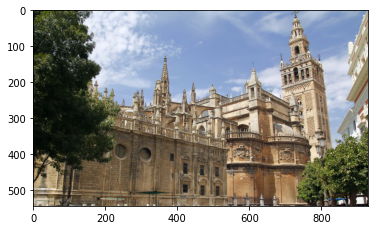

In [ ]:
 plt.imshow(load_img(target_image_path))

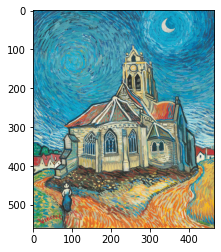

In [ ]:
plt.imshow(load_img(style_reference_image_path))

Necesitaremos un par de funciones auxiliares para preprocesar y post-procesar las imagenes que daremos y que obtedremos de la VGG19:

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Le pasaremos a la red un bloque de 3 imágenes. La imagen de referencia de estilo, la de cotenido y un contenedor donde se generará la nueva imagen. Para definir este contenedor en Keras usaremos un *placeholder*, que es simplemente un tensor simbólico. 

La imagen de referencia y la contenido son estáticas por lo que las definimos con *K.constant*, mientras que los valores del placeholder deberán ir cambiando en cada paso de la optimización con el gradiente descendente.

In [ ]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# Contenedor de la imagen a generar
combination_image = K.placeholder((1, img_height, img_width, 3))

# Combinamos las 3 imágenes un solo batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# Cargamos la VGG19 indicando que usaremos 3 imágenes como entrada
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

Definimos la función de coste de contenido:

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

Definimos una función auxiliar para calcula la matriz de Gram de una matriz de entrada:

In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

Ahora podemos definir la función de coste de estilo:

In [ ]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

Además de las componentes de estilo y contenido vamos a añadir una componente adicional para evitar un exceso de pixelado. Para ello establecemos que debe existir continuidad entre cada pixel y su vecido de la derecha y con el de abajo.

In [ ]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


La función de coste final será una media ponderada de los costes anteriores. 

Depending on the style reference image and content image you are using, you will likely want to tune the `content_weight` coefficient, the 
contribution of the content loss to the total loss. A higher `content_weight` means that the target content will be more recognizable in 
the generated image.

In [ ]:
# Diccionario con las capas de la red
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Capa de contenido
content_layer = 'block5_conv2'

# Capas de estilo
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Pesos de cada componente de la función de coste
total_variation_weight = 20#1e-4
style_weight = 100 #1.
content_weight = 1 #0.025

# Definimos la función de coste final
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

# coste de "contenido"
loss = loss + (content_weight * content_loss(target_image_features, combination_features))

# coste de "estilo"
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

# coste de "continuidad"
loss += total_variation_weight * total_variation_loss(combination_image)

Por último, configuramos el gradiente descendente. En el artículo original se usaba el algoritmo L-BFG. Dado que ya lo tenemos implementado en scipy lo usaremos también aunque tiene un par de inconvenientes:

* Es necesario pasarle el valor de la función de coste y el valor de gradientes en dos funciones por separado.
* Solo puede ser aplicada a vectores de 1D (nosotros tenemos un vector de imagenes 2D)array.

La clase `Evaluator` calculará ambos a la vez por eficiencia:

In [ ]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Por fin, podemos ejecutar el proceso del gradiente descendente usando la función fmin_l_bfgs_b de scipy. Guardaremos la imagen generada cada 100 iteraciones.

In [ ]:
# creamos el directorio tmp si no existe
if not os.path.exists('tmp'):
    os.makedirs('tmp')

result_prefix = 'tmp/style_transfer_result'
iterations = 10

x = preprocess_image(target_image_path)
# aplanamos la imagen ya que fmin_l_bfgs_b solo 
# funciona con vectores de 1D
x = x.flatten()
for i in range(iterations):
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
     
    end_time = time.time()
    
    print('Iteración', i, 'completada en %ds' % (end_time - start_time), 'con error', min_val)

    if i % 5 == 0:
        img = x.copy().reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        fname = result_prefix + '_at_iteration_%d.png' % i
        im = Image.fromarray(img)
        im.save(fname)
        


im = Image.fromarray(img)
im.save(fname)

Iteración 0 completada en 548s con error 232465330000.0
Iteración 1 completada en 534s con error 129338245000.0
Iteración 2 completada en 530s con error 100195025000.0
Iteración 3 completada en 530s con error 88368150000.0
Iteración 4 completada en 524s con error 82052210000.0
Iteración 5 completada en 524s con error 77628465000.0
Iteración 6 completada en 525s con error 74655875000.0


In [ ]:
plt.imshow(img)